In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dropout, Dense, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# load data
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

# gather to one data set
data = pd.concat([train_data, test_data], axis=0)

# only use open feature
prices = data['Open'].values.reshape(-1, 1)

print(f"shape of data: {prices.shape}")

shape of data: (1278, 1)


In [6]:
# scale data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [8]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 30  # use past 30 days data 
X, y = create_sequences(prices_scaled, look_back)

print(f"shape of X: {X.shape}")
print(f"shape of y: {y.shape}")

shape of X: (1248, 30, 1)
shape of y: (1248, 1)


In [10]:
# 70% for train, 30% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 20% in train set be validation set
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

print(f"shape of train set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"shape of validation set: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")

shape of train set: X_train=(699, 30, 1), y_train=(699, 1)
shape of validation set: X_val=(174, 30, 1), y_val=(174, 1)
shape of test set: X_test=(375, 30, 1), y_test=(375, 1)


# 1. Vanilla RNN

In [13]:
# build model
model = Sequential([
    Input(shape=(look_back, 1)),  
    SimpleRNN(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# validation set  use hyper-param
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss',  patience=3,  factor=0.1,  min_lr=0.0001,  verbose=0)

# model train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,lr_reduction],
    verbose=0
)

# predict test set
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"MSE for test set: {mse:.4f}")
print(f"MAE for test set: {mae:.4f}")
print(f"R² for test set: {r2:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MSE for test set: 184.8466
MAE for test set: 9.6837
R² for test set: 0.9916


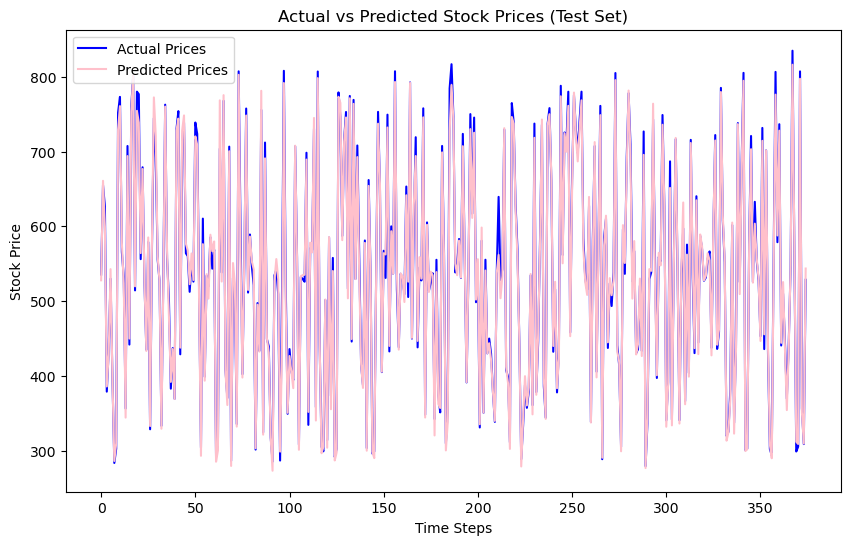

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='pink')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 2. GRU

In [20]:
model = Sequential([
    Input(shape=(look_back, 1)),  
    GRU(50, activation='tanh', return_sequences=False),  
    Dropout(0.2),  
    Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss',  patience=3,  factor=0.1,  min_lr=0.0001,  verbose=0)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,lr_reduction],
    verbose=0
)


y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)


mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)


print(f"MSE for test set: {mse:.4f}")
print(f"MAE for test set: {mae:.4f}")
print(f"R² for test set: {r2:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MSE for test set: 122.1995
MAE for test set: 7.9321
R² for test set: 0.9945


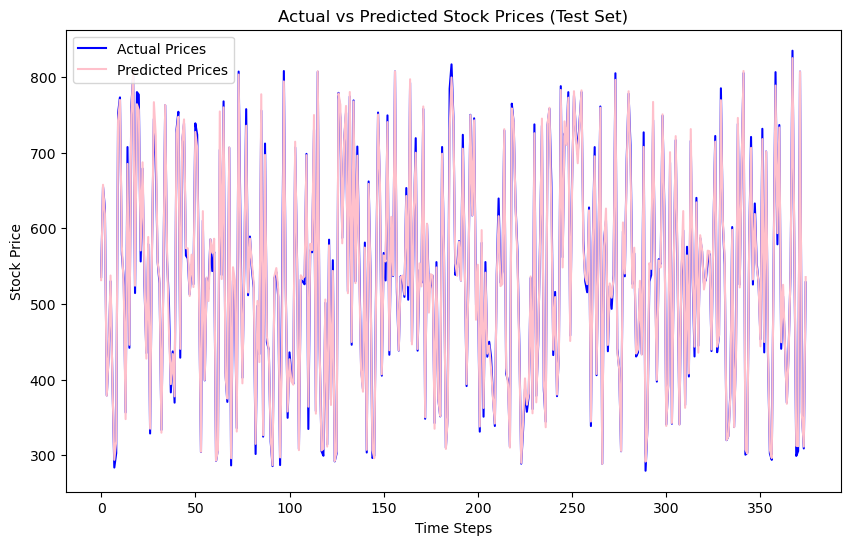

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='pink')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 3. LSTM

In [26]:
model = Sequential([
    Input(shape=(look_back, 1)),  
    LSTM(50, activation='tanh', return_sequences=False),  
    Dropout(0.2),  
    Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss',  patience=3,  factor=0.1,  min_lr=0.0001,  verbose=0)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,lr_reduction],
    verbose=0
)


y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)


mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)


print(f"MSE for test set: {mse:.4f}")
print(f"MAE for test set: {mae:.4f}")
print(f"R² for test set: {r2:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MSE for test set: 283.2914
MAE for test set: 12.1957
R² for test set: 0.9872


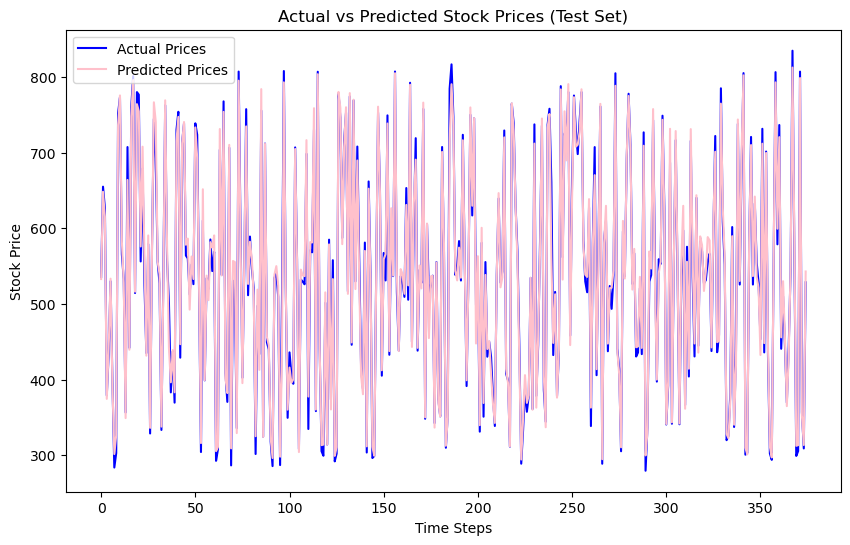

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='pink')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()